## Comparing KGs to real-world complex networks

Using three sub-KGs from the DBpedia as target

# Environment Setup

Install & imports

In [ ]:
# Install required packages
import sys
!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

# Imports
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

Auxiliary functions

In [ ]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))

    Ref.: https://stackoverflow.com/a/62662992
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

rdfs = {'oracle': 'https://dbpedia.org/data/Oracle_Corporation.ttl',
        'movie': 'https://dbpedia.org/data/Movie.ttl',
        'merged': 'http://www.ic.unicamp.br/~ra124136/kgs/dbpedia_merged_oracle_movie.ttl'}

## Loading RDF model

Pointing to a remote Turtle (*.ttl) file.

In [ ]:
rgs = dict()
for i in rdfs.keys():
    rg = RDFGraph()
    rg.parse(rdfs[i], format='ttl') # Turtle format

    print("rdflib Graph {} loaded successfully with {} triples".format(i, len(rg)))
    rgs[i] = rg

rdflib Graph oracle loaded successfully with 2577 triples
rdflib Graph movie loaded successfully with 3460 triples
rdflib Graph merged loaded successfully with 6037 triples


## Converting rdflib.Graph to networkx.MultiDiGraph

KGs are directed graphs with the possibility of multiple paralell edges.

In [ ]:
TKG = dict()
for i in rgs:
    # Conversion of rdflib.Graph to networkx.MultiDiGraph
    KG = rdflib_to_networkx_multidigraph(rgs[i])
    print("networkx Graph loaded successfully with length {}".format(len(KG)))

    TKG[i] = KG

networkx Graph loaded successfully with length 2143
networkx Graph loaded successfully with length 3411
networkx Graph loaded successfully with length 5554


# General Network Metrics

Network size and density

In [ ]:
for i in TKG:
    # Network size
    print(f"NETWORK {i} SIZE")
    print("============")
    print("The network has {} nodes and {} edges".format(TKG[i].number_of_nodes(), TKG[i].number_of_edges()))
    print()

    # Density
    print(f"NETWORK {i} DENSITY")
    print("============")
    print("The network density is {}".format(nx.density(TKG[i])))
    print()

NETWORK oracle SIZE
The network has 2143 nodes and 2577 edges

NETWORK oracle DENSITY
The network density is 0.0005614004817979455

NETWORK movie SIZE
The network has 3411 nodes and 3460 edges

NETWORK movie DENSITY
The network density is 0.00029746782661924375

NETWORK merged SIZE
The network has 5554 nodes and 6037 edges

NETWORK merged DENSITY
The network density is 0.00019574362507077347



# Scale-free Networks

In-degree distribution -- Is it Poisson's or Power-law alike?

Text(0, 0.5, 'Frequency')

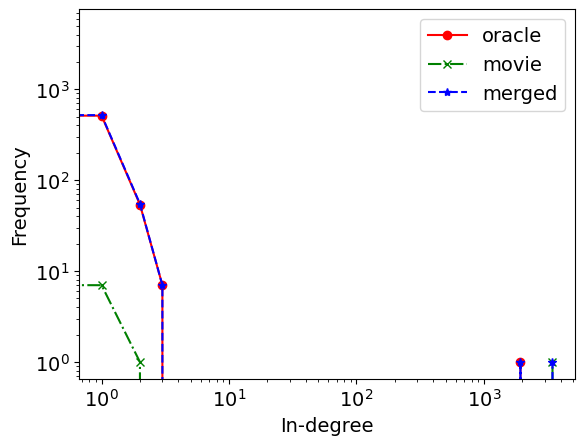

In [ ]:
styles = {'oracle': 'ro-',
          'movie': 'gx-.',
          'merged': 'b*--'}
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))

for i in TKG:
    degree_freq = degree_histogram_directed(TKG[i], in_degree=True)
    degrees = range(len(degree_freq))
    plt.loglog(degrees, degree_freq, styles[i], label=i)
plt.legend(loc="upper right")
plt.xlabel('In-degree')
plt.ylabel('Frequency')

Out-degree distribution -- Is it Poisson's or Power-law alike?

Text(0, 0.5, 'Frequency')

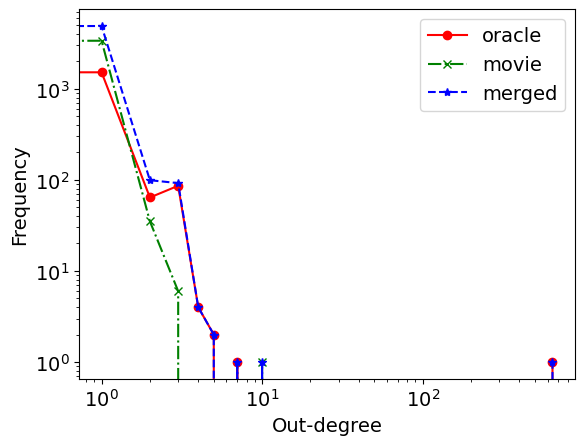

In [ ]:
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))

for i in TKG:
    degree_freq = degree_histogram_directed(TKG[i], out_degree=True)
    degrees = range(len(degree_freq))
    plt.loglog(degrees, degree_freq, styles[i], label=i)
plt.legend(loc="upper right")
plt.xlabel('Out-degree')
plt.ylabel('Frequency')

Are there HUBS available?

In [ ]:
for i in ['oracle']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network oracle Hubs:
[(rdflib.term.URIRef('http://dbpedia.org/resource/PeopleSoft'), 0.0036160298625845574), (rdflib.term.URIRef('http://dbpedia.org/resource/Vantive'), 0.0025828784732746836), (rdflib.term.URIRef('http://dbpedia.org/resource/Oracle_Multimedia'), 0.0025828784732746836), (rdflib.term.URIRef('http://dbpedia.org/resource/Wercker'), 0.002066302778619747), (rdflib.term.URIRef('http://dbpedia.org/resource/BlueKai'), 0.002066302778619747), (rdflib.term.URIRef('http://dbpedia.org/resource/Sun_Microsystems'), 0.002066302778619747), (rdflib.term.URIRef('http://dbpedia.org/resource/RightNow_Technologies'), 0.002066302778619747), (rdflib.term.URIRef('http://dbpedia.org/resource/Incomit'), 0.0015497270839648102), (rdflib.term.URIRef('http://dbpedia.org/resource/Micros_Systems'), 0.0015497270839648102), (rdflib.term.URIRef('http://dbpedia.org/resource/TOA_Technologies'), 0.0015497270839648102), (rdflib.term.URIRef('http://dbpedia.org/resource/Oracle_Cloud'), 0.0015497270839648102), (

In [ ]:
for i in ['movie']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network movie Hubs:
[(rdflib.term.URIRef('http://dbpedia.org/resource/Ten_Thirty-One_Pictures_Entertainment'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Pece_Trajkovski_–_Brada'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Centropolis_Entertainment'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Jacso_Group'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Sunset_Gower_Studios'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/DViant_Films'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Versailles_(album)'), 0.0005795416407455997), (rdflib.term.URIRef('http://dbpedia.org/resource/Solidão,_Uma_Linda_História_de_Amor'), 0.0005795416407455997), (rdflib.term.URIRef('http://dbpedia.org/resource/Meera_Ke_Girdhar'), 0.0005795416407455997), (rdflib.term.URIRef("http://dbpedia.org/resource/L'est_Films_Group"), 0.00057954164074559

In [ ]:
for i in ['merged']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network merged Hubs:
[(rdflib.term.URIRef('http://dbpedia.org/resource/Ten_Thirty-One_Pictures_Entertainment'), 0.000869312461118374), (rdflib.term.URIRef('http://dbpedia.org/resource/Centropolis_Entertainment'), 0.000869312461118374), (rdflib.term.URIRef('http://dbpedia.org/resource/Sunset_Gower_Studios'), 0.000869312461118374), (rdflib.term.URIRef('http://dbpedia.org/resource/Jacso_Group'), 0.000869312461118374), (rdflib.term.URIRef('http://dbpedia.org/resource/DViant_Films'), 0.000869312461118374), (rdflib.term.URIRef('http://dbpedia.org/resource/Pece_Trajkovski_–_Brada'), 0.000869312461118374), (rdflib.term.URIRef('http://dbpedia.org/resource/Meera_Ke_Girdhar'), 0.0005795416407455826), (rdflib.term.URIRef("http://dbpedia.org/resource/L'est_Films_Group"), 0.0005795416407455826), (rdflib.term.URIRef('http://dbpedia.org/resource/Sandra_Kerns'), 0.0005795416407455826), (rdflib.term.URIRef('http://dbpedia.org/resource/Il_Cuore_nel_Pozzo'), 0.0005795416407455826), (rdflib.term.URIRef('ht

# Communities

Check for communities using the Clauset-Newman-Moore Algorithm (greedy modularity - applicable to directed graphs)

In [ ]:
for k in TKG:
    comms = nx.community.greedy_modularity_communities(TKG[k])

    print(f'Network {k} -- Found {len(comms)} communities.')
    idx = 0
    for i in comms:
        print(f'Community {idx} has {len(i)} nodes.')
        #print(i)
        idx = idx + 1

Network oracle -- Found 1 communities.
Community 0 has 2143 nodes.
Network movie -- Found 3403 communities.
Community 0 has 9 nodes.
Community 1 has 1 nodes.
Community 2 has 1 nodes.
Community 3 has 1 nodes.
Community 4 has 1 nodes.
Community 5 has 1 nodes.
Community 6 has 1 nodes.
Community 7 has 1 nodes.
Community 8 has 1 nodes.
Community 9 has 1 nodes.
Community 10 has 1 nodes.
Community 11 has 1 nodes.
Community 12 has 1 nodes.
Community 13 has 1 nodes.
Community 14 has 1 nodes.
Community 15 has 1 nodes.
Community 16 has 1 nodes.
Community 17 has 1 nodes.
Community 18 has 1 nodes.
Community 19 has 1 nodes.
Community 20 has 1 nodes.
Community 21 has 1 nodes.
Community 22 has 1 nodes.
Community 23 has 1 nodes.
Community 24 has 1 nodes.
Community 25 has 1 nodes.
Community 26 has 1 nodes.
Community 27 has 1 nodes.
Community 28 has 1 nodes.
Community 29 has 1 nodes.
Community 30 has 1 nodes.
Community 31 has 1 nodes.
Community 32 has 1 nodes.
Community 33 has 1 nodes.
Community 34 has 1

# Small-world networks

Does it have a low average shortest path?

In [ ]:
for i in TKG:
    if nx.is_strongly_connected(TKG[i]):
        print(f'Network {i} -- Average shortest path length: {nx.average_shortest_path_length(TKG[i])}')
    else:
        print(f'Network {i} is NOT strongly connected!')

Network oracle is NOT strongly connected!
Network movie is NOT strongly connected!
Network merged is NOT strongly connected!


Does it have a high clustering coefficient?

In [ ]:
for i in TKG:
    # create weighted graph from M, as method is not implemented for MultiDiGraphs
    DG = nx.DiGraph()
    for u,v in TKG[i].edges():
        if DG.has_edge(u,v):
            DG[u][v]['weight'] += 1
        else:
            DG.add_edge(u, v, weight=1)

    ccs = nx.clustering(DG,weight='weight').values()

    print(f"Network {i} -- Clustering coefficient: {sum(ccs)/len(ccs)}")

Network oracle -- Clustering coefficient: 0.0
Network movie -- Clustering coefficient: 0.0
Network merged -- Clustering coefficient: 0.0


# Some Centrality Measurements

NW oracle DEGREE CENTRALITY
The mean degree centrality is 0.001122800963595889, with stdev 0.025998199048061884
The maximum node is http://dbpedia.org/resource/Oracle_Corporation, with value 1.2040149393090571
The minimum node is http://dbpedia.org/resource/Greg_Maffei, with value 0.00046685340802987864
(1.2040149393090571, 0.003734827264239029, 0.002334267040149393, 0.0018674136321195146, 0.0014005602240896359, 0.0009337068160597573, 0.00046685340802987864) (1, 1, 7, 21, 83, 169, 1861)


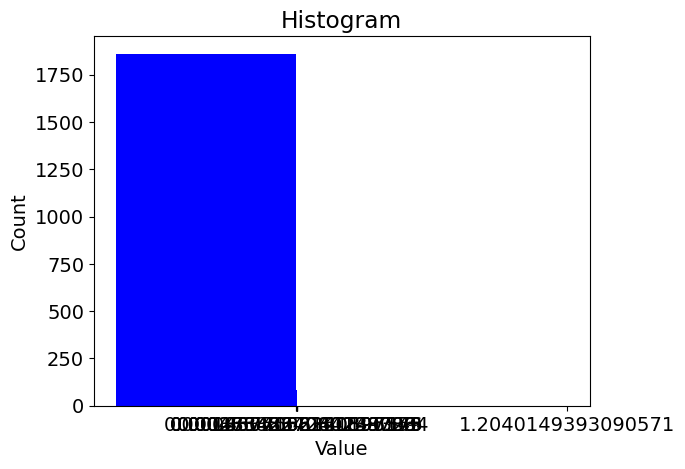


NW movie DEGREE CENTRALITY
The mean degree centrality is 0.0005949356532384491, with stdev 0.01737321324851645
The maximum node is http://dbpedia.org/resource/Movie, with value 1.0149560117302052
The minimum node is http://dbpedia.org/resource/Quickie_Express, with value 0.0002932551319648094
(1.0149560117302052, 0.0008797653958944282, 0.0005865102639296188, 0.0002932551319648094) (1, 6, 37, 3367)


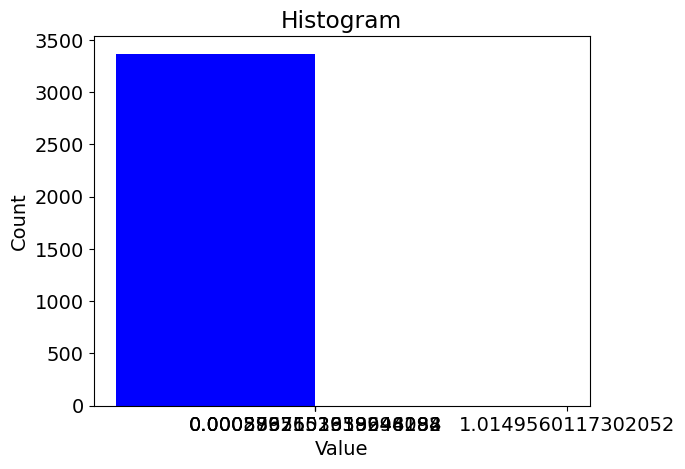


NW merged DEGREE CENTRALITY
The mean degree centrality is 0.0003914872501415756, with stdev 0.010425398572788127
The maximum node is http://dbpedia.org/resource/Movie, with value 0.6232667026832344
The minimum node is http://dbpedia.org/resource/Greg_Maffei, with value 0.00018008283810552856
(0.6232667026832344, 0.46443363947415817, 0.0014406627048442284, 0.0009004141905276428, 0.0007203313524221142, 0.0005402485143165856, 0.0003601656762110571, 0.00018008283810552856) (1, 1, 1, 7, 21, 89, 206, 5228)


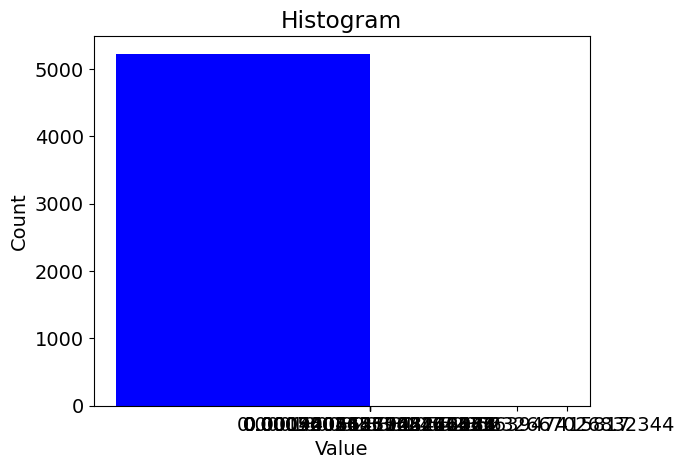


NW oracle PAGERANK
The mean network pagerank is 0.0004666355576294998, with stdev 0.00683014779920644
The maximum node is http://dbpedia.org/resource/Oracle_Corporation, with value 0.31633780829325
The minimum node is http://dbpedia.org/resource/Greg_Maffei, with value 0.00019369021409684442
(0.31633780829325, 0.0014496610230282424, 0.0010310040867177765, 0.0006123471504073104, 0.00019369021409684442) (1, 7, 54, 513, 1568)


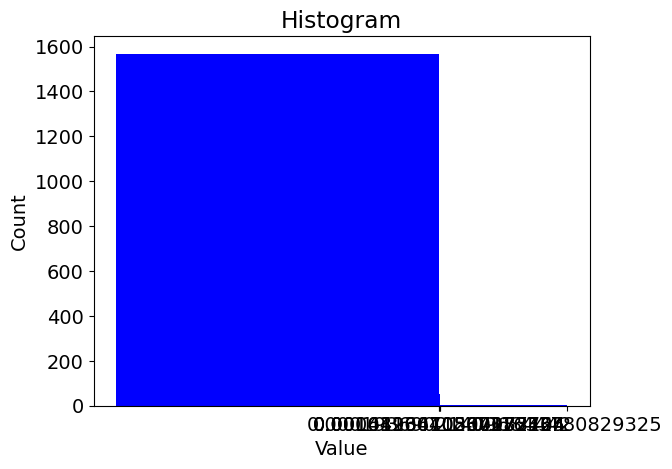


NW movie PAGERANK
The mean network pagerank is 0.00029316915860447485, with stdev 0.006438348855769643
The maximum node is http://dbpedia.org/resource/Movie, with value 0.3621245843252478
The minimum node is http://dbpedia.org/resource/Quickie_Express, with value 0.00010584961486130537
(0.3621245843252478, 0.061645456058787115, 0.030875652836824204, 0.00010584961486130537) (1, 1, 7, 3402)


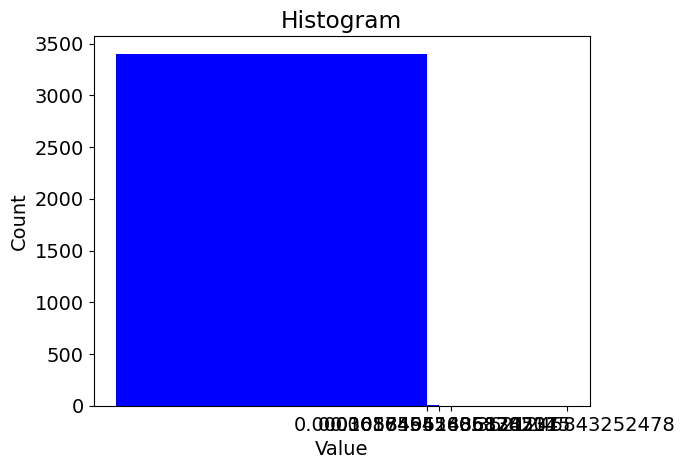


NW merged PAGERANK
The mean network pagerank is 0.00018005041411592356, with stdev 0.003607769675722958
The maximum node is http://dbpedia.org/resource/Movie, with value 0.23554300240961207
The minimum node is http://dbpedia.org/resource/Greg_Maffei, with value 6.829654697841186e-05
(0.23554300240961207, 0.11201980538649081, 0.039834224982597394, 0.0199512607647879, 0.0005089885349196886, 0.0003620912056059296, 0.00021519387629217074, 6.829654697841186e-05) (1, 1, 1, 7, 7, 54, 513, 4970)


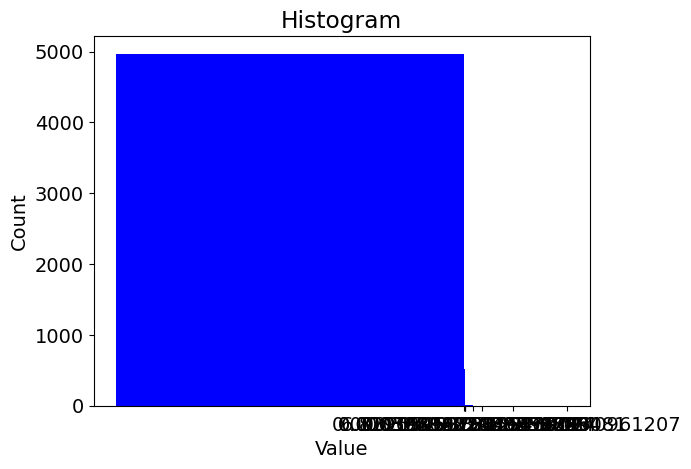


NW oracle BETWEENNESS CENTRALITY
The mean betwenness centrality is 9.758507442400435e-05, with stdev 0.004517461741506544
The maximum node is http://dbpedia.org/resource/Oracle_Corporation, with value 0.20912481449064133
The minimum node is http://dbpedia.org/resource/Greg_Maffei, with value 0.0
(0.20912481449064133, 0.0) (1, 2142)


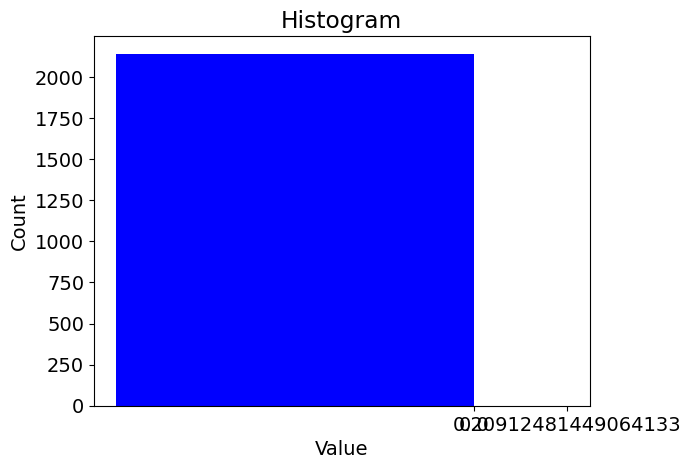


NW movie BETWEENNESS CENTRALITY
The mean betwenness centrality is 6.865511256378197e-07, with stdev 4.009717197657155e-05
The maximum node is http://dbpedia.org/resource/Movie, with value 0.002341825889550603
The minimum node is http://dbpedia.org/resource/Quickie_Express, with value 0.0
(0.002341825889550603, 0.0) (1, 3410)


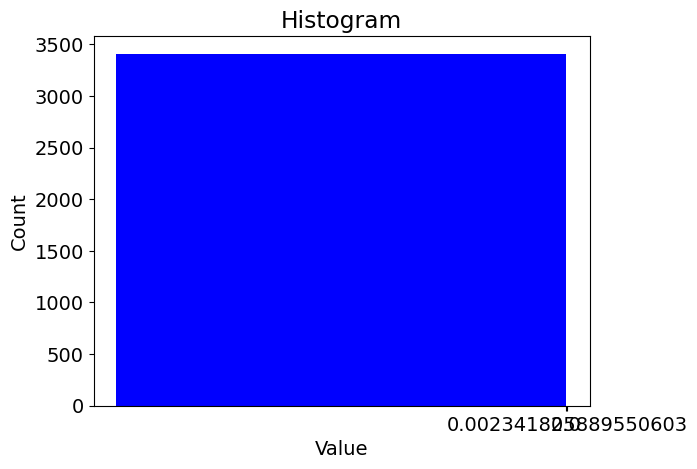


NW merged BETWEENNESS CENTRALITY
The mean betwenness centrality is 5.759895154026516e-06, with stdev 0.00041757482413171424
The maximum node is http://dbpedia.org/resource/Oracle_Corporation, with value 0.031107461449557863
The minimum node is http://dbpedia.org/resource/Greg_Maffei, with value 0.0
(0.031107461449557863, 0.0008829962359054041, 0.0) (1, 1, 5552)


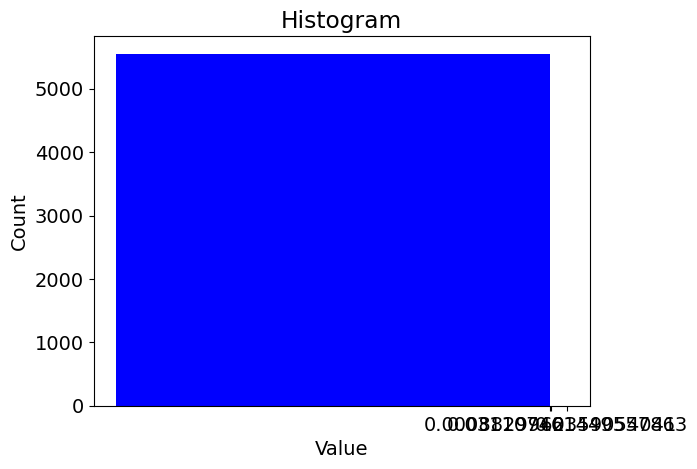

In [ ]:
for i in TKG:
    # Degree centrality -- mean and stdev
    dc = nx.degree_centrality(TKG[i])
    degrees = []
    for k,v in dc.items():
        degrees.append(v)

    print(f"NW {i} DEGREE CENTRALITY")
    print("=================")
    print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
    print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
    histogram(dc)
    print()

for i in TKG:
    # PageRank -- mean and stdev
    pc = nx.pagerank(TKG[i])
    degrees = []
    for k,v in pc.items():
        degrees.append(v)

    print(f"NW {i} PAGERANK")
    print("======================")
    print("The mean network pagerank is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(pc, key=pc.get), max(pc.values())))
    print("The minimum node is {}, with value {}".format(min(pc, key=pc.get), min(pc.values())))
    histogram(pc)
    print()

for i in TKG:
    # Betweenness centrality -- mean and stdev
    bc = nx.betweenness_centrality(TKG[i])
    degrees = []
    for k,v in bc.items():
        degrees.append(v)

    print(f"NW {i} BETWEENNESS CENTRALITY")
    print("======================")
    print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
    print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
    histogram(bc)
    print()